In [1]:
%matplotlib inline

import mindspore as ms
from mindspore import nn
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
#生成随机数据
num_inputs = 2
num_examples = 1000
true_w = [2, 3]
true_b = [4]
features = ms.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=ms.float32)
labels = (true_w[0] * features[:, 0] + true_w[1] * features[:, 1]).add(true_b[0])
labels += ms.tensor(np.random.normal(0, 0.0001, size=labels.shape[0]), dtype=ms.float32)

#输出第一组数据
print(features[0], labels[0])

[ 0.6075197 -0.5828399] 3.466497


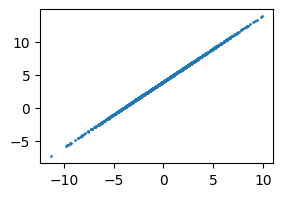

In [4]:
#数据集可视化
figsize=(3, 2)

plt.rcParams['figure.figsize'] = figsize
plt.scatter((true_w[0] * features[:, 0] + true_w[1] * features[:, 1]).numpy(), labels.numpy(), 1);

In [34]:
#读取数据
def data_iter(batch, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  #随机读取样本
    batch_size = int(num_examples/batch)
    for i in range(0, num_examples, batch_size):
        j = ms.Tensor(indices[i: min(i + batch_size, num_examples)]) #不足一个batch时取上限
        yield  features.index_select(0, j), labels.index_select(0, j)

In [35]:
#读取第一批数据
batch = 25

for X, y in data_iter(batch, features, labels):
    print(X, y)
    break

[[ 1.1345261   0.11096215]
 [-0.16419946 -1.5069277 ]
 [-1.032268   -0.36171758]
 [ 1.4191353   0.31511143]
 [-1.0949265  -1.510645  ]
 [ 0.98150146 -0.3911277 ]
 [-0.62493116  1.2934427 ]
 [-1.3554134   0.32810622]
 [-1.6132714  -1.3337575 ]
 [ 0.1169376  -0.05867843]
 [ 1.2753088   0.3199281 ]
 [-0.04158127 -0.19178137]
 [-0.11917656 -0.47794646]
 [ 0.593295    0.70432955]
 [ 0.30716696  0.4730472 ]
 [-2.4423738   1.6347735 ]
 [-0.355032   -1.3124368 ]
 [ 0.3123567  -0.3270502 ]
 [ 0.28662223  0.242562  ]
 [ 1.38513    -0.45216465]
 [-1.0448308  -1.5977285 ]
 [ 1.6316649   2.0322585 ]
 [-1.7731285   0.5318282 ]
 [-0.05738116 -1.3778396 ]
 [-0.45982766  0.0050547 ]
 [ 0.53246754 -0.49166137]
 [ 1.4615144   1.1419243 ]
 [-0.9886448  -1.0053686 ]
 [-0.9467007  -0.16463345]
 [ 0.04576056 -0.0737803 ]
 [-1.4980257   0.05006213]
 [-1.4624207  -0.36029986]
 [ 0.695714    0.22885874]
 [-1.3932348   0.7498592 ]
 [ 0.26931202 -0.5730941 ]
 [ 1.2334733   1.5775439 ]
 [ 0.6776653  -1.8247238 ]
 

In [45]:
# 定义前馈神经网络
class Forward_fashion(nn.Cell):
    def __init__(self):
        super().__init__()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(2, 1)
        )

    def construct(self, x):
        logits = self.dense_relu_sequential(x)
        return logits

In [46]:
#创建模型、损失函数和优化算法
model = Forward_fashion()

loss_fn = nn.MSELoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=0.0005)

In [47]:
#模型训练

#正向计算
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

#计算梯度
grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

#单步训练
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

#完整训练函数
def train(model, features, labels):
    model.set_train()
    for i in range(1000):
        for data, label in data_iter(25, features, labels):
            loss = train_step(data, label)
        print(loss.asnumpy())

In [48]:
#训练模型
train(model, features, labels)

34.225903
30.103638
27.675747
25.541527
24.752789
28.484192
19.4417
10.324715
34.384445
23.065039
17.302794
14.73193
15.147113
22.69791
14.571853
24.711071
23.139427
23.785347
22.178211
18.938478
22.662016
19.422312
22.767122
17.679356
15.361393
19.646822
16.052057
12.430943
17.036736
19.44192
18.780706
15.0784445
14.158891
12.282601
20.009344
10.995101
14.22952
17.91607
12.998688
14.615662
17.802666
18.722313
13.220027
15.852203
11.569454
20.60622
14.326704
9.171764
15.204578
12.827151
7.311245
14.403576
25.131104
12.484464
12.636986
17.542377
13.773369
14.028132
12.41991
13.149488
13.701834
16.244967
14.012005
15.848628
15.62005
14.104785
15.048549
9.979513
15.588589
16.648611
14.932237
11.597686
11.158331
12.393105
13.519109
18.981705
12.94263
13.265641
17.210993
15.272765
12.029223
15.007991
11.980459
10.36709
9.972718
14.888618
13.782428
11.364572
21.709251
14.514237
12.709342
14.281551
15.354376
10.219337
15.027277
13.04701
13.2346
12.175536
16.486143
16.651215
16.894539
8.581858

In [44]:
print(model.dense_relu_sequential[0].weight[0])
print(model.dense_relu_sequential[0].bias[0])

[0.01896361 0.02704964]
3.8274314
